In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.1
!pip install scikit-multilearn
!pip install gspread

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 23.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.1 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.2 which is incompatible.
mlxtend 0.20.0 requires scikit-learn>=1.0.2, but you have scikit-learn 0.24.1 which is incompatible.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 0.24.1 which is incompatible.
gplearn 0.4.2 requires scikit-learn>=1.0.2, but you have scikit-learn 0.24.1 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
import re
from sklearn.metrics import *
import time

In [3]:
def cm_labels(cm):
    label_names = ['TN', 'FP', 'FN', 'TP']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{ln}\n{c}\n{p}" for ln, c, p in zip(label_names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    return labels

In [4]:
def eval_metrics(y_test, title='Confusion Matrix', pred=None, pred_proba=None, multilabel=False):
    target_names = list(y_test.columns)    
    if multilabel:
        if len(pred.shape) == 1:
            num = np.unique(y_pred, axis=0)
            num = num.shape[0]
            pred_converted = np.eye(num)[pred]
            pred = pred_converted

        total_accuracy = accuracy_score(y_test, pred)
        print(f'total accuracy: {total_accuracy}')
        
        accuracy_dict = {}
        for i, y in enumerate(y_test.columns):
            accuracy = accuracy_score(y_test[y], pred[:, i])
            accuracy_dict[y] = accuracy
            print(f'{y} accuracy: {accuracy}')
        
        fig1, axes1 = plt.subplots(2, 2, figsize=(17, 17))
        fig2, axes2 = plt.subplots(2, 2, figsize=(17, 17))

        axes_list1 = [ax for sublist in axes1 for ax in sublist]
        axes_list2 = [ax for sublist in axes2 for ax in sublist]
        flattend_axes = axes_list1 + axes_list2

        cms = multilabel_confusion_matrix(y_test, pred)
        for i, ax in enumerate(flattend_axes):
            labels = cm_labels(cms[i])
            sns.heatmap(cms[i], annot=labels, fmt='', cmap='Blues', ax=ax).set(title=f'{title} - {target_names[i]}')
    else:
        accuracy = accuracy_score(y_test, pred)
        print(f'accuracy: {accuracy}')
        
        cm = confusion_matrix(y_test, pred)
        labels = cm_labels(cm)
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax).set(title=title)
    
    print(classification_report(y_test, pred, target_names=target_names))
    plt.show()
    
    report_dict = classification_report(y_test, pred, target_names=target_names, output_dict=True)
    
    for k, v in accuracy_dict.items():
        report_dict[k]['accuracy'] = v
    
    report_dict['total accuracy'] = total_accuracy
    return report_dict

# DATA B

In [5]:
data_a = pd.read_csv('../input/sleep-research/preprocessed_data_b.csv')
data_a.head()

,sex,age,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control,...,Supine0 A+H+RERA_Index(h),Lateral A+H+RERA_ Index(h),REM A+H+RERA Index(/h),NREM A+H+RERA Index(/h),Apnea_Max_ Length(sec),Hypopnea_Max_ Length(sec),Resp. Arousal /(A+H)(%),ODI,90%ODI,EtCO2 (>50mmHg)
0,1,52,0,0,0,0,0,0,0,1,...,0.4,0.0,0.0,0.0,0.0,42.7,100.0,0.0,0.0,0.0
1,0,65,1,0,1,0,0,0,0,0,...,20.9,0.0,0.0,0.0,70.6,61.4,90.2,0.0,0.0,0.0
2,0,53,1,0,0,0,0,0,0,0,...,45.8,0.0,0.0,0.0,57.7,93.4,73.1,0.0,0.0,0.0
3,0,53,1,1,0,0,0,0,0,0,...,26.8,0.0,0.0,0.0,22.7,89.9,78.2,0.0,0.0,0.0
4,1,55,1,0,0,0,0,0,0,0,...,15.4,2.1,0.0,0.0,15.2,47.7,28.2,0.0,0.0,0.0


In [6]:
from sklearn.model_selection import train_test_split

target_a = data_a.iloc[:, 2:10]
features_a = data_a.drop(data_a.iloc[:, 2:10], axis=1)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(features_a, target_a, test_size=0.3)
y_train_converted_a = y_train_a.apply(lambda y: y.argmax(), axis=1).values

In [7]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skmultilearn.ensemble import RakelD
from sklearn.model_selection import GridSearchCV

parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=XGBClassifier(tree_method='gpu_hist', gpu_id=0)), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, True], 'labelset_size': 8} 0.8203127809668718


total accuracy: 0.7388105456774985
OSA accuracy: 0.9086450030656039
insomnia accuracy: 0.9037400367872471
PLMD, RLS accuracy: 0.9086450030656039
parasomnia accuracy: 0.9509503372164316
circadian rhythm sleep-wake disorder accuracy: 0.9773145309625997
Narcolepsy, EDS, Hypersomnia accuracy: 0.9717964438994482
Catathrenia accuracy: 0.9981606376456161
control accuracy: 0.9374616799509503


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.92      0.96      0.94      1243
                            insomnia       0.47      0.36      0.41       150
                           PLMD, RLS       0.59      0.42      0.49       171
                          parasomnia       0.28      0.07      0.11        72
circadian rhythm sleep-wake disorder       0.14      0.03      0.05        32
        Narcolepsy, EDS, Hypersomnia       0.59      0.20      0.30        49
                         Catathrenia       0.00      0.00      0.00         3
                             control       0.50      0.61      0.55       103

                           micro avg       0.82      0.77      0.79      1823
                           macro avg       0.44      0.33      0.36      1823
                        weighted avg       0.78      0.77      0.77      1823
                         samples avg       0.83      0.80     

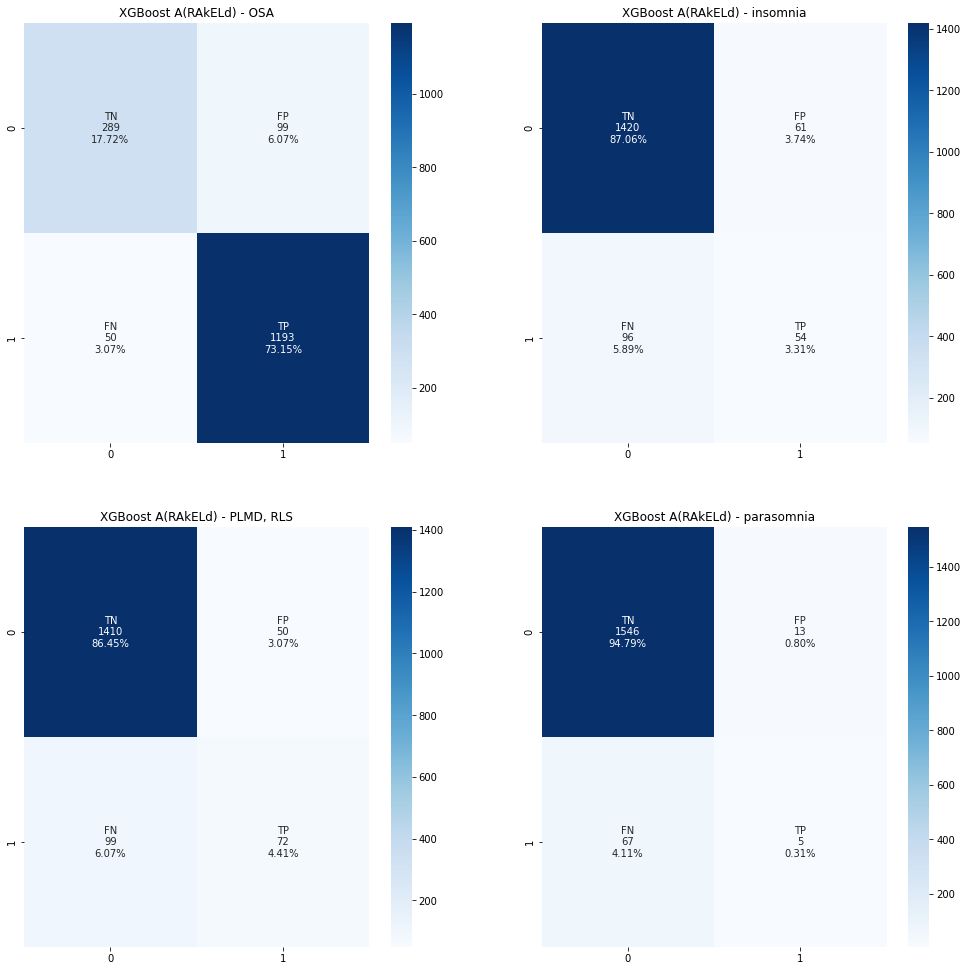

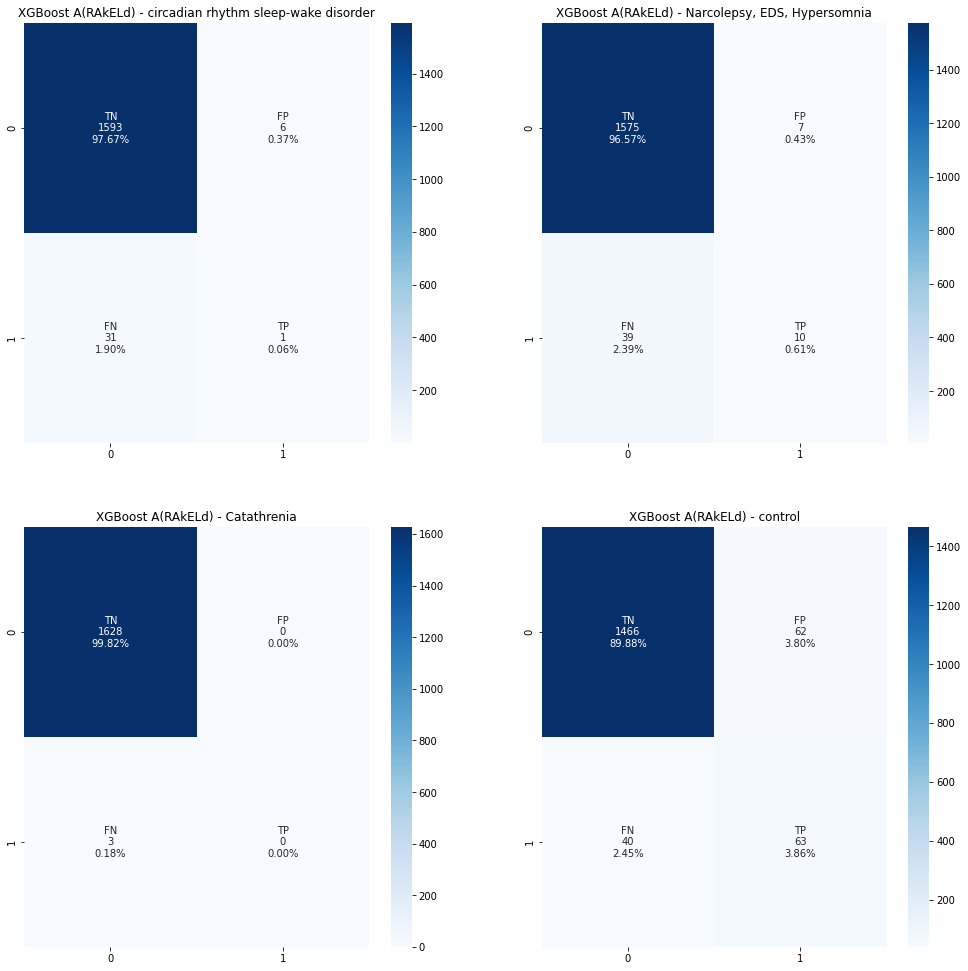

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='XGBoost A(RAkELd)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [9]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [10]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+10, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+10, cell.col, score)

In [11]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=RandomForestClassifier()), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, True], 'labelset_size': 8} 0.8156780897710767


total accuracy: 0.7473942366646229
OSA accuracy: 0.9074187614960147
insomnia accuracy: 0.9172286940527283
PLMD, RLS accuracy: 0.911710606989577
parasomnia accuracy: 0.9558553034947884
circadian rhythm sleep-wake disorder accuracy: 0.9803801348865726
Narcolepsy, EDS, Hypersomnia accuracy: 0.9711833231146536
Catathrenia accuracy: 0.9981606376456161
control accuracy: 0.9325567136725935


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.91      0.98      0.94      1243
                            insomnia       0.57      0.40      0.47       150
                           PLMD, RLS       0.75      0.24      0.36       171
                          parasomnia       0.00      0.00      0.00        72
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        32
        Narcolepsy, EDS, Hypersomnia       0.75      0.06      0.11        49
                         Catathrenia       0.00      0.00      0.00         3
                             control       0.48      0.69      0.56       103

                           micro avg       0.84      0.76      0.80      1823
                           macro avg       0.43      0.30      0.31      1823
                        weighted avg       0.78      0.76      0.75      1823
                         samples avg       0.84      0.80     

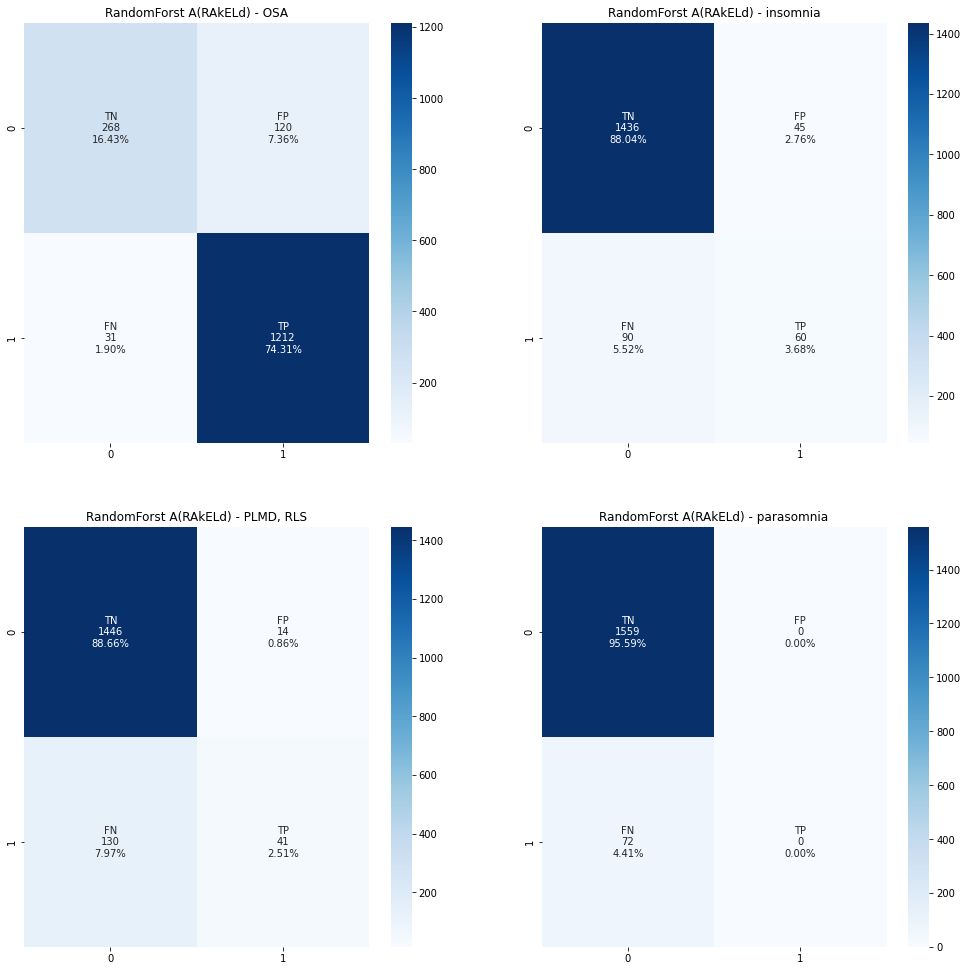

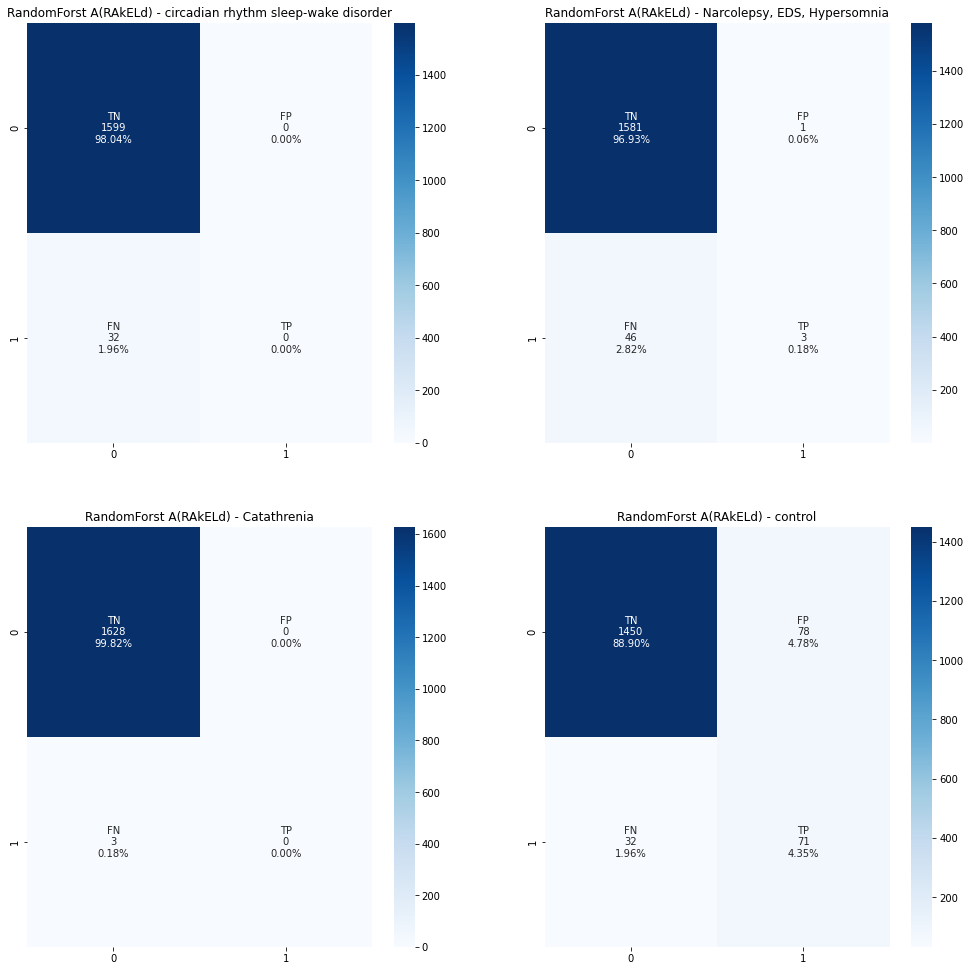

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='RandomForst A(RAkELd)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [13]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [14]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+4, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+4, cell.col, score)

In [15]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=LGBMClassifier(device='gpu')), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [False, True], 'labelset_size': 6} 0.7951246743665997


total accuracy: 0.6051502145922747
OSA accuracy: 0.7835683629675047
insomnia accuracy: 0.8491722869405273
PLMD, RLS accuracy: 0.8755364806866953
parasomnia accuracy: 0.9135499693439607
circadian rhythm sleep-wake disorder accuracy: 0.979767014101778
Narcolepsy, EDS, Hypersomnia accuracy: 0.9681177191906806
Catathrenia accuracy: 0.9981606376456161
control accuracy: 0.9294911097486205


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.83      0.90      0.86      1243
                            insomnia       0.25      0.32      0.28       150
                           PLMD, RLS       0.36      0.25      0.29       171
                          parasomnia       0.03      0.03      0.03        72
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        32
        Narcolepsy, EDS, Hypersomnia       0.00      0.00      0.00        49
                         Catathrenia       0.00      0.00      0.00         3
                             control       0.12      0.02      0.03       103

                           micro avg       0.69      0.66      0.68      1823
                           macro avg       0.20      0.19      0.19      1823
                        weighted avg       0.63      0.66      0.64      1823
                         samples avg       0.71      0.69     

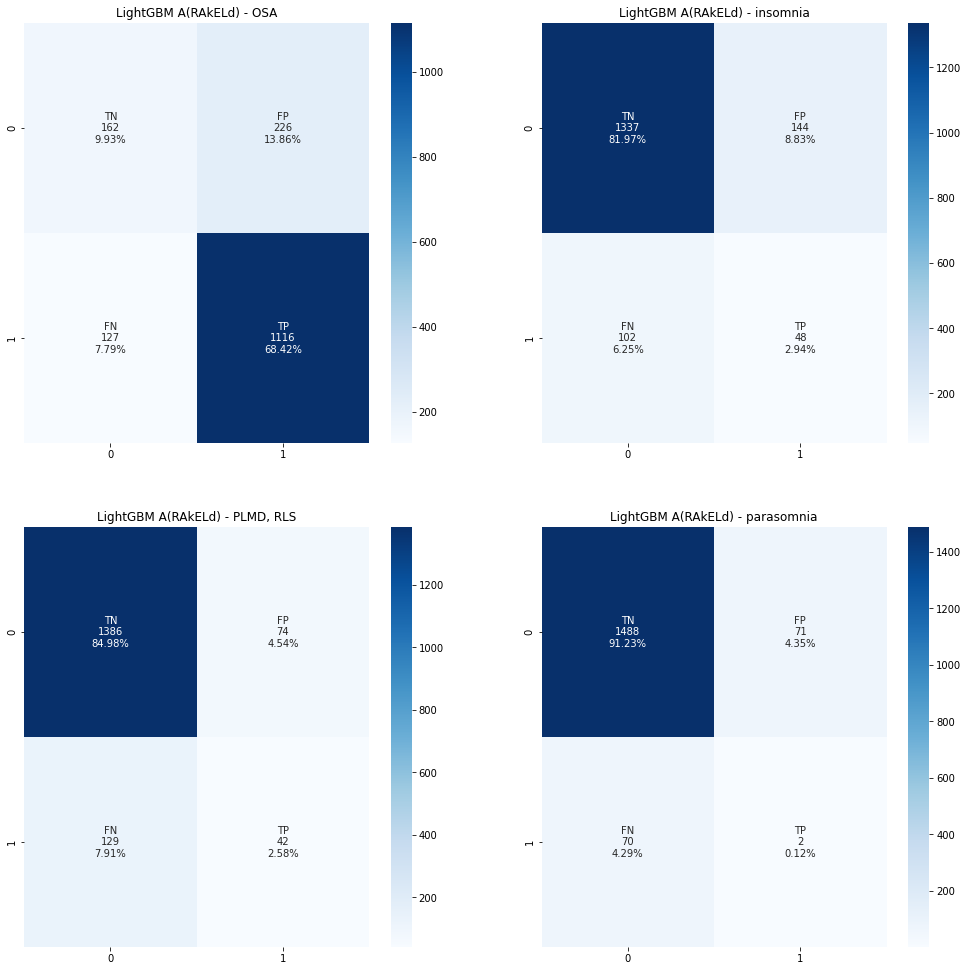

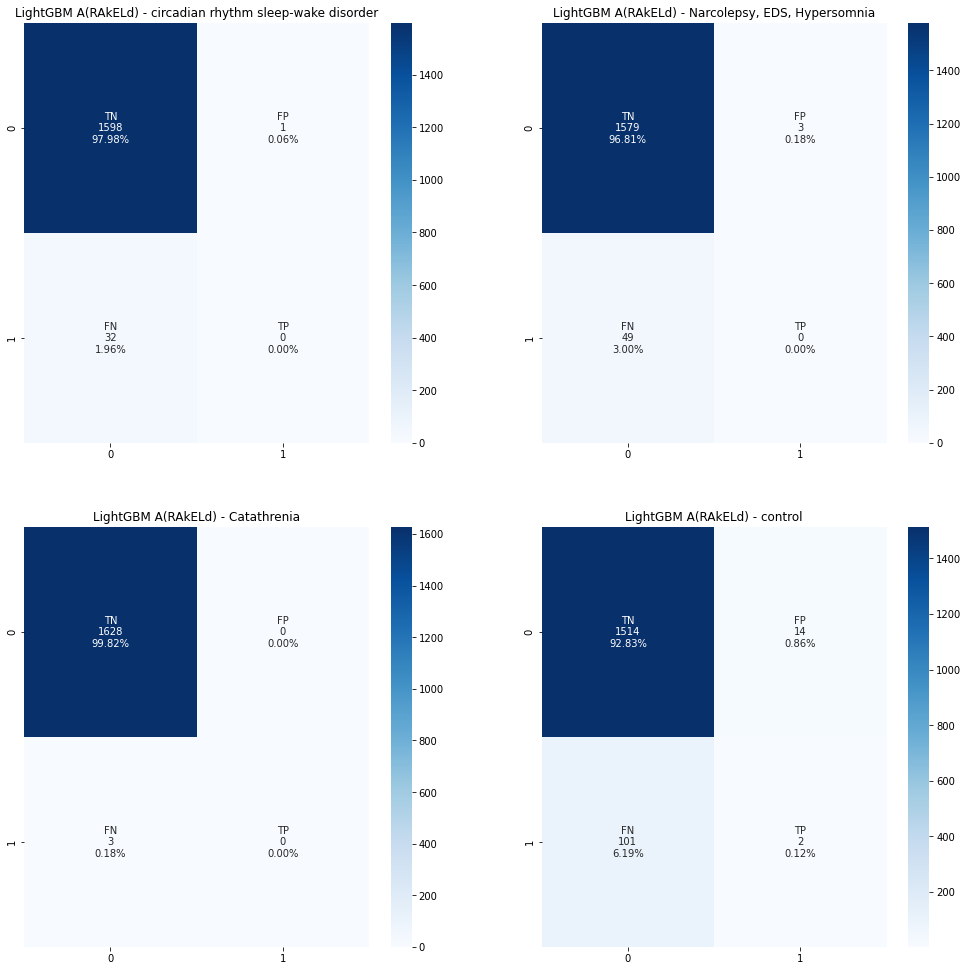

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='LightGBM A(RAkELd)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [17]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [18]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+16, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+16, cell.col, score)

## MLSMOTE

In [19]:
X_a = features_a.to_numpy()
Y_a = target_a.to_numpy()

In [20]:
from sklearn.neighbors import NearestNeighbors


def IRLbl(Y):
    # imbalance ratio per label
    pos_nums_per_label = np.sum(Y, axis=0)
    max_pos_nums = np.max(pos_nums_per_label)
    return max_pos_nums / pos_nums_per_label


def MeanIR(Y):
    # average imbalance ratio
    IRLbl_VALUE = IRLbl(Y)
    return np.mean(IRLbl_VALUE)


def TailLabel(Y):
    n, m = Y.shape
    irlbl = IRLbl(Y)
    mean_ir = MeanIR(Y)
    return np.where(irlbl>=mean_ir)[0]


def MinBag(X, Y, label_index):
    pos = np.where(Y[:,label_index]==1)
    sample_index = list(set(pos[0]))
    X_minor, Y_minor = X[sample_index,:], Y[sample_index,:]
    return X_minor, Y_minor


def NN_index(X, k=5):
    # n_neighbors including the sample itself, 
    # so we take the number of n_neighbors as k+1 (as the following shows),
    # then delete itself from the neighbors.
    nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean', 
                           algorithm='auto').fit(X)
    euclidean, index = nn.kneighbors(X)
    return index[:,1:]


def MLSMOTE(X_minor, Y_minor, k=5):
    n, p = X_minor.shape
    m = Y_minor.shape[1]
    X_synth = np.zeros((n,p))
    Y_synth = np.zeros((n,m))
    
    nn_index = NN_index(X_minor, k=5)
    for i in range(n):
        # generate sample feature, that is, X
        sample_X = X_minor[i,:]
        rand_ind = np.random.randint(0, k)
        ref_index = nn_index[i,rand_ind]
        refNeigh = X_minor[ref_index,:]
        diff = sample_X - refNeigh
        offset = diff*np.random.uniform(0, 1, (1,p))
        X_synth[i,:] = sample_X + offset
        
        # generate sample labels Y with the voting method
        sample_nn_index = nn_index[i,:]
        nn_label = Y_minor[sample_nn_index,:]
        Y_synth[i,:] = (np.sum(nn_label, axis=0)>=((k+1)/2))
    X_new = np.r_[X_minor, X_synth]
    Y_new = np.r_[Y_minor, Y_synth]
    return X_new, Y_new

In [21]:
label_index_a = TailLabel(Y_a)

X_minor_a, Y_minor_a = MinBag(X_a, Y_a, label_index_a)
X_new_a, Y_new_a = MLSMOTE(X_minor_a, Y_minor_a, k=5)

print(X_new_a.shape, Y_new_a.shape)

(16, 61) (16, 8)


In [22]:
mlsmote_data_a = pd.DataFrame(X_new_a, columns=data_a.columns[:2].tolist()+data_a.columns[10:].tolist())
mlsmote_label_a = pd.DataFrame(Y_new_a, columns=data_a.columns[2:10].tolist())

X_df_a = pd.concat([features_a, mlsmote_data_a], axis=0)
Y_df_a = pd.concat([target_a, mlsmote_label_a], axis=0)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_df_a, Y_df_a, test_size=0.3)
y_train_converted_a = y_train_a.apply(lambda y: y.argmax(), axis=1).values

In [23]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=XGBClassifier(tree_method='gpu_hist', gpu_id=0)), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [False, False], 'labelset_size': 8} 0.8190825688073394


total accuracy: 0.7492354740061162
OSA accuracy: 0.9143730886850153
insomnia accuracy: 0.9149847094801223
PLMD, RLS accuracy: 0.9045871559633027
parasomnia accuracy: 0.9553516819571866
circadian rhythm sleep-wake disorder accuracy: 0.9779816513761468
Narcolepsy, EDS, Hypersomnia accuracy: 0.9718654434250764
Catathrenia accuracy: 0.9969418960244648
control accuracy: 0.946177370030581
                                      precision    recall  f1-score   support

                                 OSA       0.92      0.96      0.94      1224
                            insomnia       0.49      0.43      0.46       136
                           PLMD, RLS       0.57      0.38      0.45       171
                          parasomnia       0.42      0.07      0.12        71
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        32
        Narcolepsy, EDS, Hypersomnia       0.45      0.20      0.28        44
                         Catathrenia       1.00      0.55      0.71

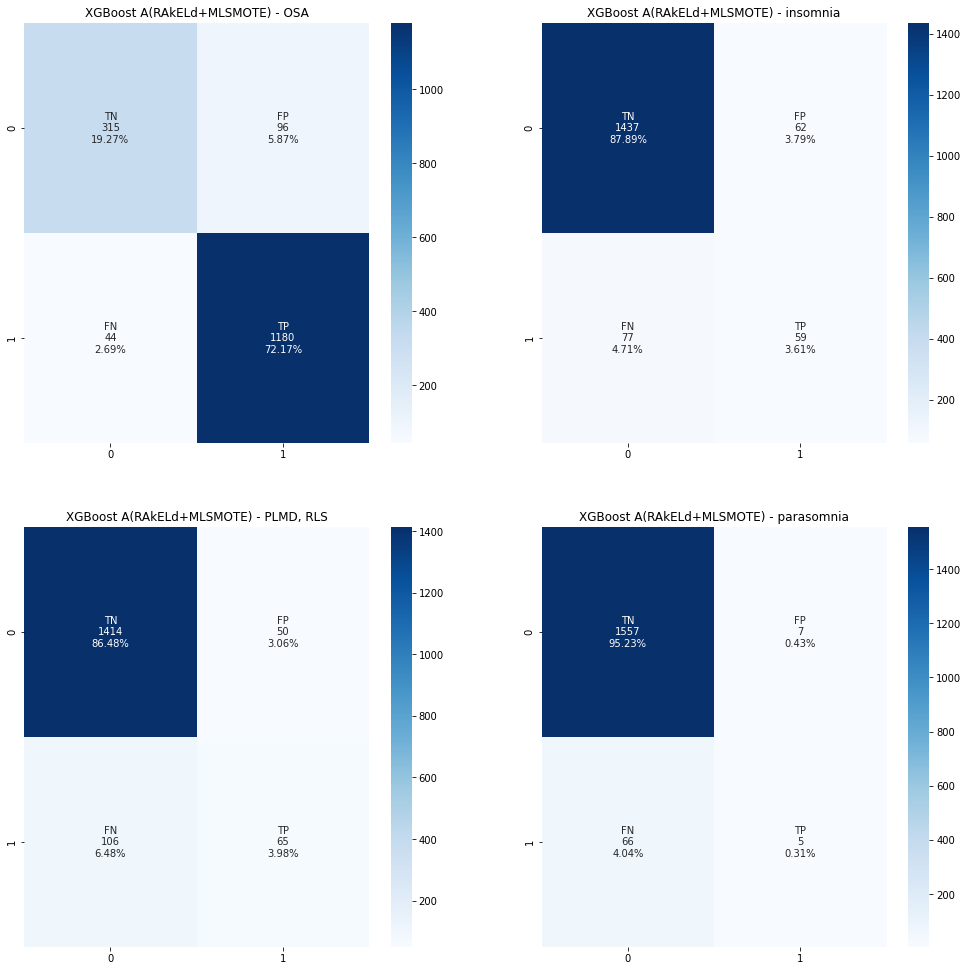

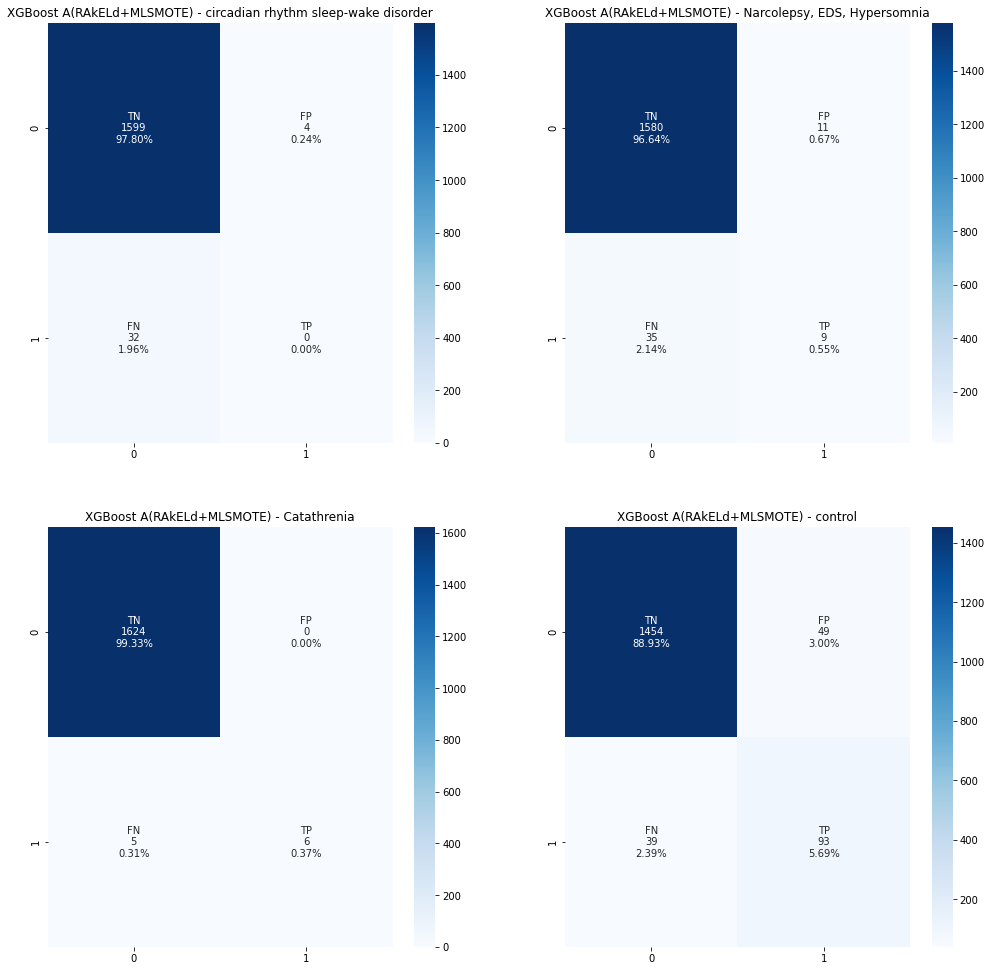

In [24]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='XGBoost A(RAkELd+MLSMOTE)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [25]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [26]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+11, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+11, cell.col, score)

In [27]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=LGBMClassifier(device='gpu')), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [False, False], 'labelset_size': 6} 0.7789078200087374


total accuracy: 0.6629969418960244
OSA accuracy: 0.8403669724770643
insomnia accuracy: 0.9314984709480122
PLMD, RLS accuracy: 0.872782874617737
parasomnia accuracy: 0.9529051987767584
circadian rhythm sleep-wake disorder accuracy: 0.9798165137614679
Narcolepsy, EDS, Hypersomnia accuracy: 0.9602446483180428
Catathrenia accuracy: 0.9938837920489296
control accuracy: 0.8990825688073395


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.85      0.96      0.90      1224
                            insomnia       0.64      0.41      0.50       136
                           PLMD, RLS       0.32      0.19      0.24       171
                          parasomnia       0.36      0.11      0.17        71
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        32
        Narcolepsy, EDS, Hypersomnia       0.16      0.11      0.13        44
                         Catathrenia       1.00      0.09      0.17        11
                             control       0.38      0.39      0.38       132

                           micro avg       0.75      0.73      0.74      1821
                           macro avg       0.46      0.28      0.31      1821
                        weighted avg       0.70      0.73      0.70      1821
                         samples avg       0.77      0.76     

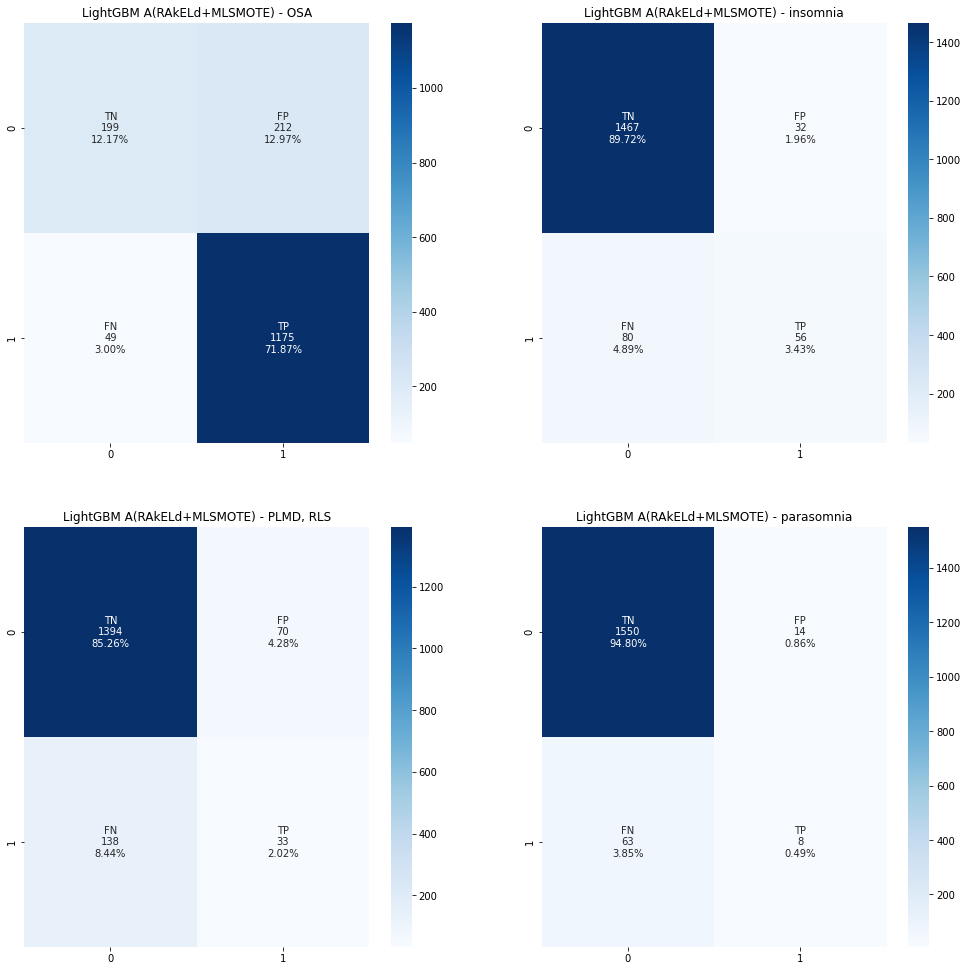

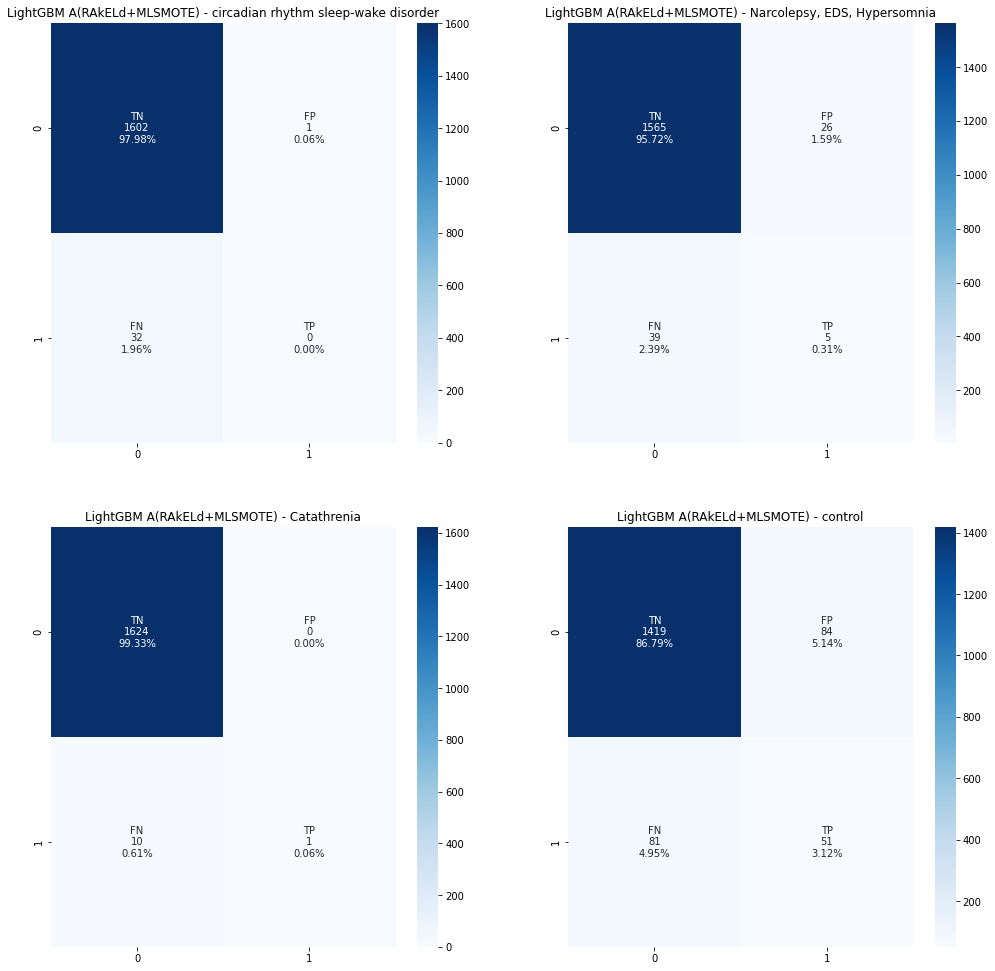

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='LightGBM A(RAkELd+MLSMOTE)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [29]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [30]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+17, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+17, cell.col, score)

In [31]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=RandomForestClassifier()), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [False, False], 'labelset_size': 8} 0.8107208387942333


total accuracy: 0.7559633027522936
OSA accuracy: 0.9235474006116208
insomnia accuracy: 0.9180428134556575
PLMD, RLS accuracy: 0.9009174311926605
parasomnia accuracy: 0.9559633027522936
circadian rhythm sleep-wake disorder accuracy: 0.9798165137614679
Narcolepsy, EDS, Hypersomnia accuracy: 0.9761467889908257
Catathrenia accuracy: 0.9969418960244648
control accuracy: 0.9376146788990826
                                      precision    recall  f1-score   support

                                 OSA       0.92      0.98      0.95      1224
                            insomnia       0.51      0.40      0.45       136
                           PLMD, RLS       0.57      0.20      0.30       171
                          parasomnia       0.00      0.00      0.00        71
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        32
        Narcolepsy, EDS, Hypersomnia       1.00      0.11      0.20        44
                         Catathrenia       1.00      0.55      0.7

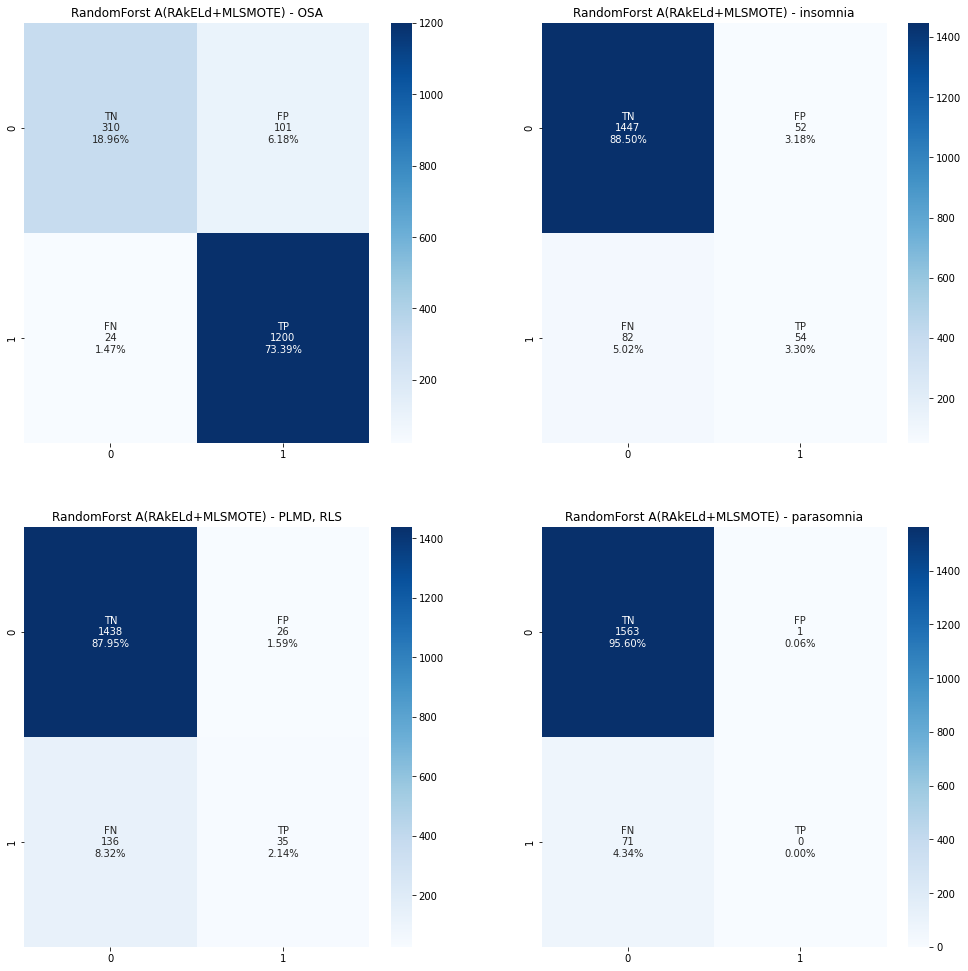

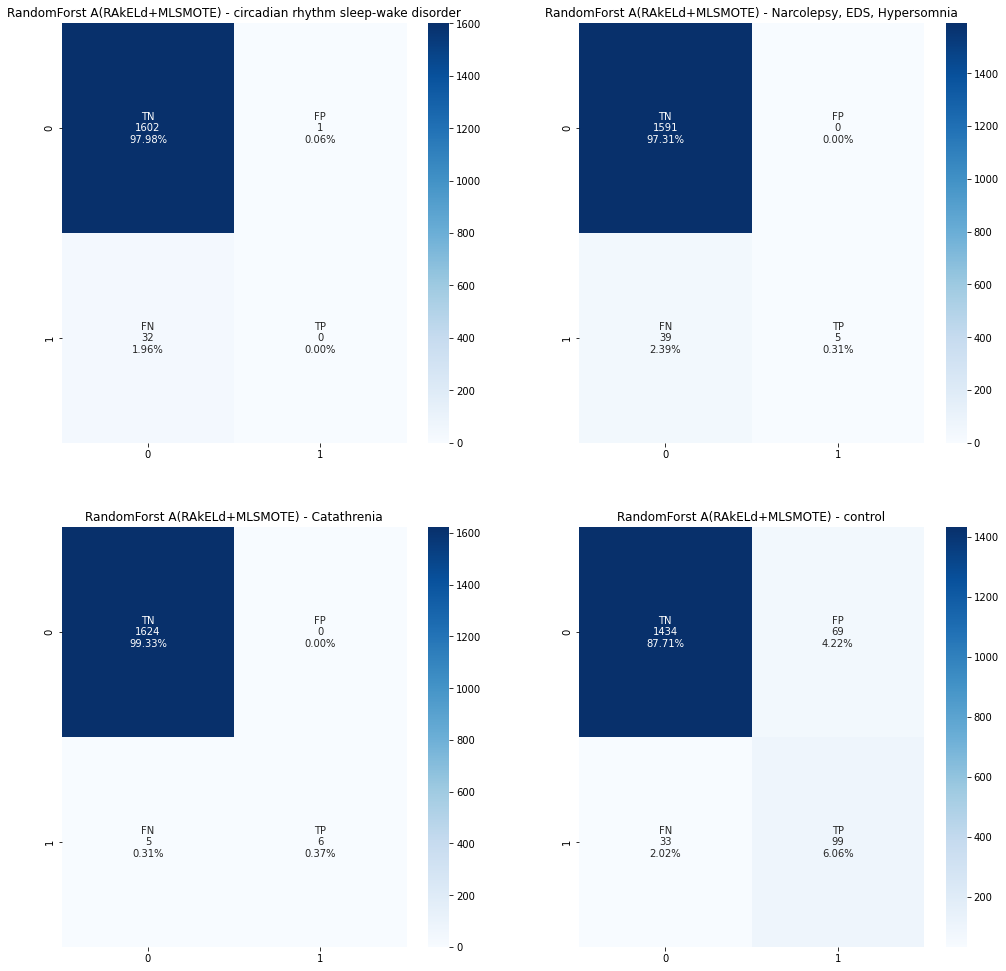

In [32]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='RandomForst A(RAkELd+MLSMOTE)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [33]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [34]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+5, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+5, cell.col, score)

## MLeNN

In [35]:
def caculate_IRLbl(Y):
    # imbalance ratio per label
    posNumsPerLabel = np.sum(Y, axis=0)
    maxPosNums = np.max(posNumsPerLabel)
    return maxPosNums / posNumsPerLabel


def caculate_meanIR(Y):
    # average imbalance ratio
    IRLbl = caculate_IRLbl(Y)
    return np.mean(IRLbl)


def get_minBag(Y):
    n, m = Y.shape
    IRLbl = caculate_IRLbl(Y)
    meanIR = caculate_meanIR(Y)
    return [i for i in range(m) if IRLbl[i] > meanIR]


def get_minMajInstInd(Y, minBag):
    n, m = Y.shape
    minInstInd = []
    majInstInd = []
    for i in range(n):
        if (Y[i, minBag]==1).any():
            minInstInd.append(i)
        else:
            majInstInd.append(i)
    return minInstInd, majInstInd


def adjust_hamming_distance(y1, y2):
    flag1 = np.sum(y1)
    flag2 = np.sum(y2)
    if flag1 and flag2:
        ele = np.sum((y1 + y2)==1)
        den = flag1 + flag2
        return ele / den
    else:
        return 1


def NN_index(X, k=5):
    # n_neighbors including the sample itself, 
    # so we take the number of n_neighbors as k+1 (as the following shows),
    # then delete itself from the neighbors.
    nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean', 
                           algorithm='auto').fit(X)
    euclidean, index = nn.kneighbors(X)
    return index[:,1:]


def MLeNN(X, Y, NN=3, HT=0.75):
    # MLeNN (MultiLabel edited Nearest Neighbor)
    nnIndex = NN_index(X, NN)
    minBag = get_minBag(Y)
    minInstInd, majInstInd = get_minMajInstInd(Y, minBag)
    markForRemoving = []
    for sampleIndex in majInstInd:
        numDifferences = 0
        sampleNNIndexs = nnIndex[sampleIndex,:]
        for sampleNNIndex in sampleNNIndexs:
            adjustedHammingDist = adjust_hamming_distance(Y[sampleIndex,:],
                                                          Y[sampleNNIndex,:])
            if adjustedHammingDist > HT:
                numDifferences = numDifferences + 1
        if numDifferences >= (NN/2):
#             print("Remove:", sampleIndex)
            markForRemoving.append(sampleIndex)
    
    X_new = np.delete(X, markForRemoving, axis=0)
    Y_new = np.delete(Y, markForRemoving, axis=0)
    return X_new, Y_new

In [36]:
X_new_a, Y_new_a = MLeNN(X_a, Y_a, NN=3, HT=0.75)
print(X_new_a.shape, Y_new_a.shape)

(4292, 61) (4292, 8)


In [37]:
mlenn_data_a = pd.DataFrame(X_new_a, columns=data_a.columns[:2].tolist()+data_a.columns[10:].tolist())
mlenn_label_a = pd.DataFrame(Y_new_a, columns=data_a.columns[2:10].tolist())

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(mlenn_data_a, mlenn_label_a, test_size=0.3)
y_train_converted_a = y_train_a.apply(lambda y: y.argmax(), axis=1).values

In [38]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=XGBClassifier(tree_method='gpu_hist', gpu_id=0)), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, True], 'labelset_size': 6} 0.9339325198742836


total accuracy: 0.843167701863354
OSA accuracy: 0.9774844720496895
insomnia accuracy: 0.967391304347826
PLMD, RLS accuracy: 0.9145962732919255
parasomnia accuracy: 0.9658385093167702
circadian rhythm sleep-wake disorder accuracy: 0.9930124223602484
Narcolepsy, EDS, Hypersomnia accuracy: 0.9860248447204969
Catathrenia accuracy: 0.9984472049689441
control accuracy: 0.9914596273291926


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.98      0.99      0.99      1157
                            insomnia       0.76      0.53      0.62        66
                           PLMD, RLS       0.52      0.28      0.37       113
                          parasomnia       0.50      0.05      0.08        44
circadian rhythm sleep-wake disorder       0.00      0.00      0.00         9
        Narcolepsy, EDS, Hypersomnia       0.75      0.15      0.25        20
                         Catathrenia       0.00      0.00      0.00         2
                             control       0.88      0.93      0.91        57

                           micro avg       0.95      0.87      0.91      1468
                           macro avg       0.55      0.37      0.40      1468
                        weighted avg       0.91      0.87      0.88      1468
                         samples avg       0.96      0.92     

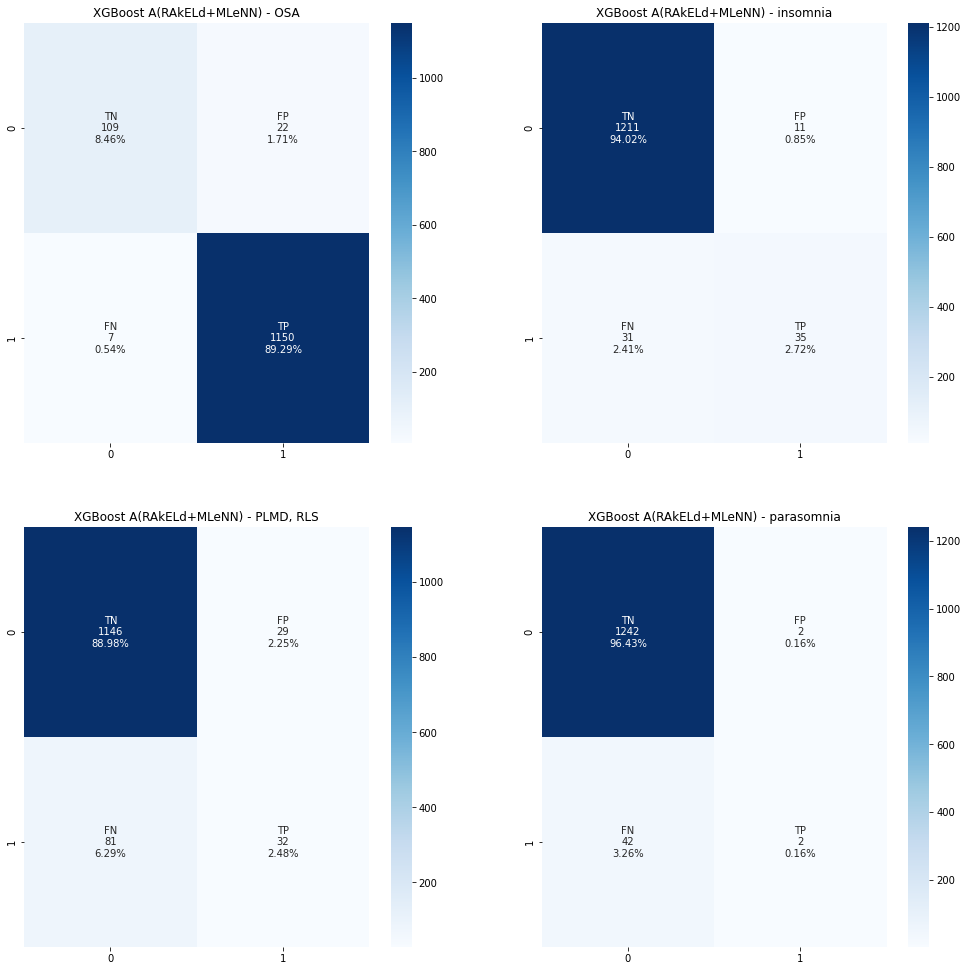

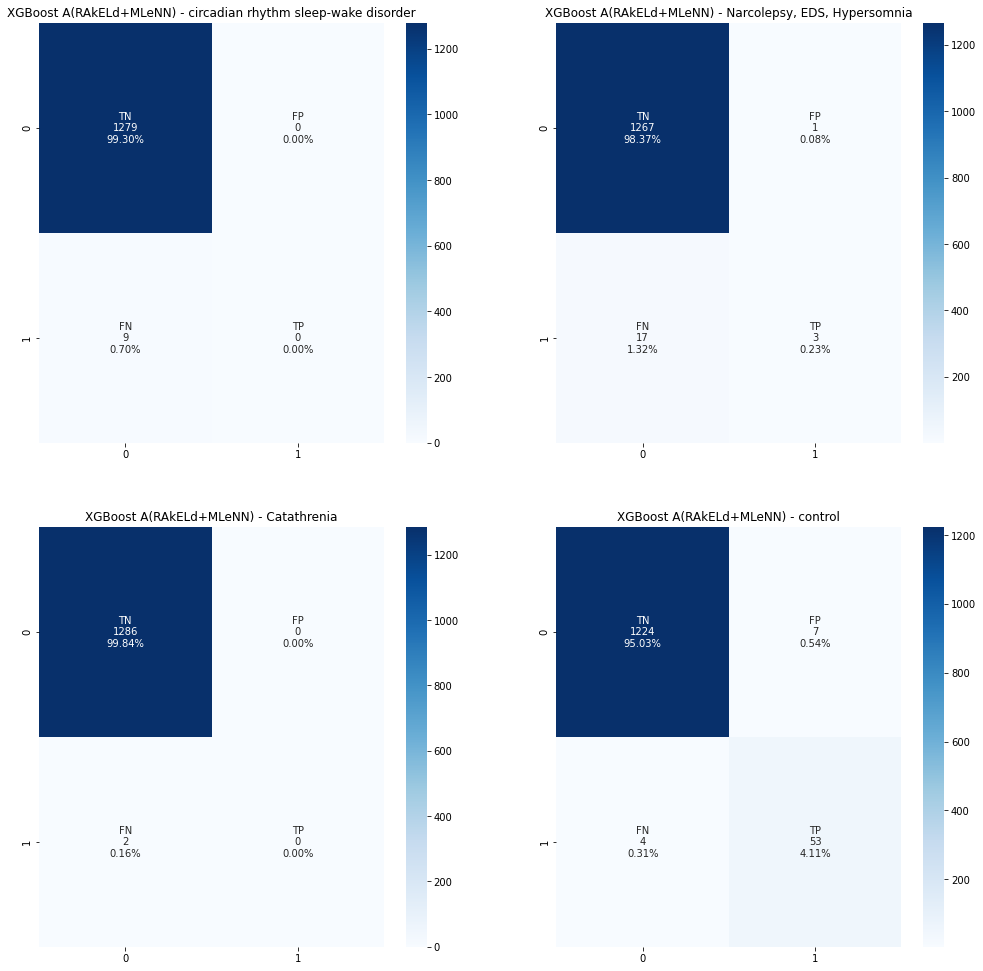

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='XGBoost A(RAkELd+MLeNN)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [40]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [41]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+12, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+12, cell.col, score)

In [42]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=RandomForestClassifier()), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [False, True], 'labelset_size': 10} 0.9302916435570345


total accuracy: 0.8470496894409938
OSA accuracy: 0.9728260869565217
insomnia accuracy: 0.968944099378882
PLMD, RLS accuracy: 0.9169254658385093
parasomnia accuracy: 0.9658385093167702
circadian rhythm sleep-wake disorder accuracy: 0.9930124223602484
Narcolepsy, EDS, Hypersomnia accuracy: 0.985248447204969
Catathrenia accuracy: 0.9984472049689441
control accuracy: 0.9891304347826086


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.97      1.00      0.99      1157
                            insomnia       0.81      0.52      0.63        66
                           PLMD, RLS       0.61      0.15      0.24       113
                          parasomnia       0.00      0.00      0.00        44
circadian rhythm sleep-wake disorder       0.00      0.00      0.00         9
        Narcolepsy, EDS, Hypersomnia       1.00      0.05      0.10        20
                         Catathrenia       0.00      0.00      0.00         2
                             control       0.84      0.93      0.88        57

                           micro avg       0.96      0.86      0.90      1468
                           macro avg       0.53      0.33      0.35      1468
                        weighted avg       0.90      0.86      0.86      1468
                         samples avg       0.96      0.91     

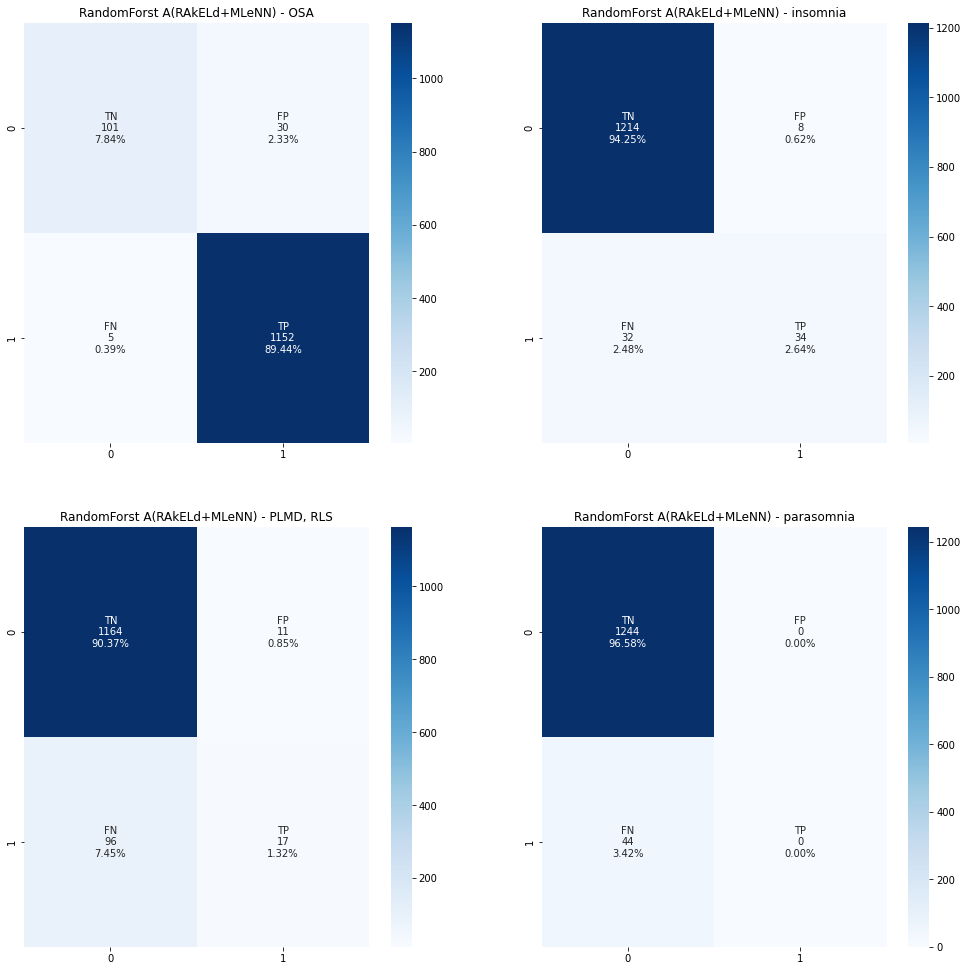

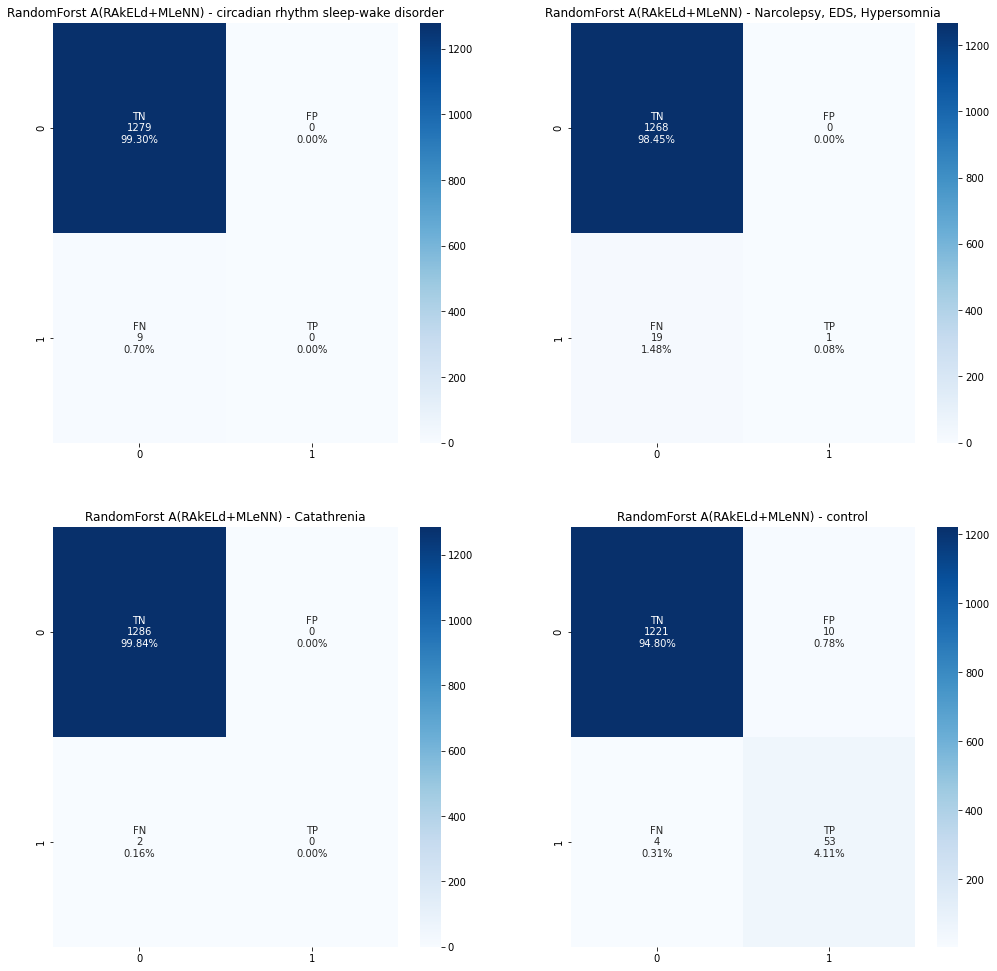

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='RandomForst A(RAkELd+MLeNN)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [44]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [45]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+6, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+6, cell.col, score)

In [46]:
parameters = {
    'base_classifier_require_dense': [[True, True], [True, False], [False, False], [False, True]],
    'labelset_size': list(range(6, 14))
}
score = 'f1_samples'

rakeld_clf = GridSearchCV(RakelD(base_classifier=LGBMClassifier(device='gpu')), parameters, scoring=score)
rakeld_clf.fit(X_train_a, y_train_a)

print(rakeld_clf.best_params_, rakeld_clf.best_score_)

/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
/opt/conda/lib/python3.7/site-packages/skmultilearn/cluster/random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

{'base_classifier_require_dense': [True, True], 'labelset_size': 6} 0.9368608800147902


total accuracy: 0.6327639751552795
OSA accuracy: 0.8400621118012422
insomnia accuracy: 0.8493788819875776
PLMD, RLS accuracy: 0.8361801242236024
parasomnia accuracy: 0.9572981366459627
circadian rhythm sleep-wake disorder accuracy: 0.9930124223602484
Narcolepsy, EDS, Hypersomnia accuracy: 0.96972049689441
Catathrenia accuracy: 0.9984472049689441
control accuracy: 0.9487577639751553


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.90      0.92      0.91      1157
                            insomnia       0.15      0.42      0.22        66
                           PLMD, RLS       0.16      0.21      0.19       113
                          parasomnia       0.08      0.02      0.04        44
circadian rhythm sleep-wake disorder       0.00      0.00      0.00         9
        Narcolepsy, EDS, Hypersomnia       0.00      0.00      0.00        20
                         Catathrenia       0.00      0.00      0.00         2
                             control       0.00      0.00      0.00        57

                           micro avg       0.72      0.76      0.74      1468
                           macro avg       0.16      0.20      0.17      1468
                        weighted avg       0.73      0.76      0.74      1468
                         samples avg       0.78      0.80     

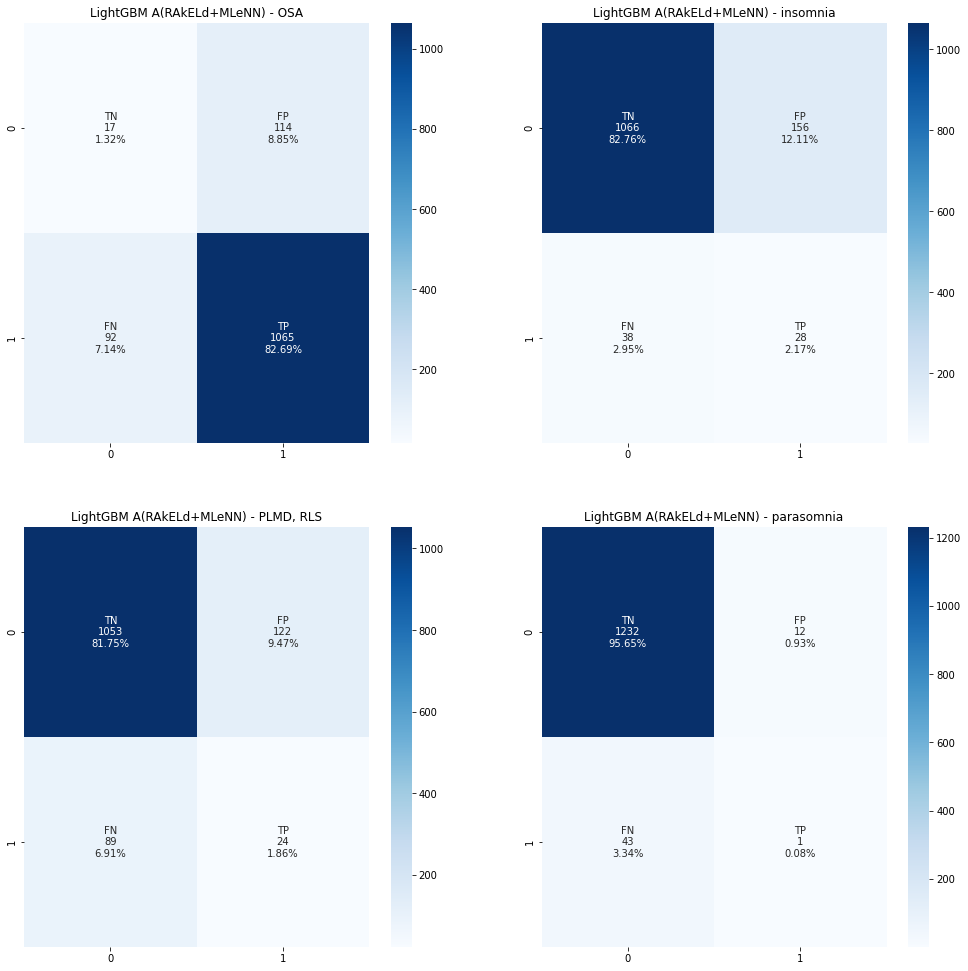

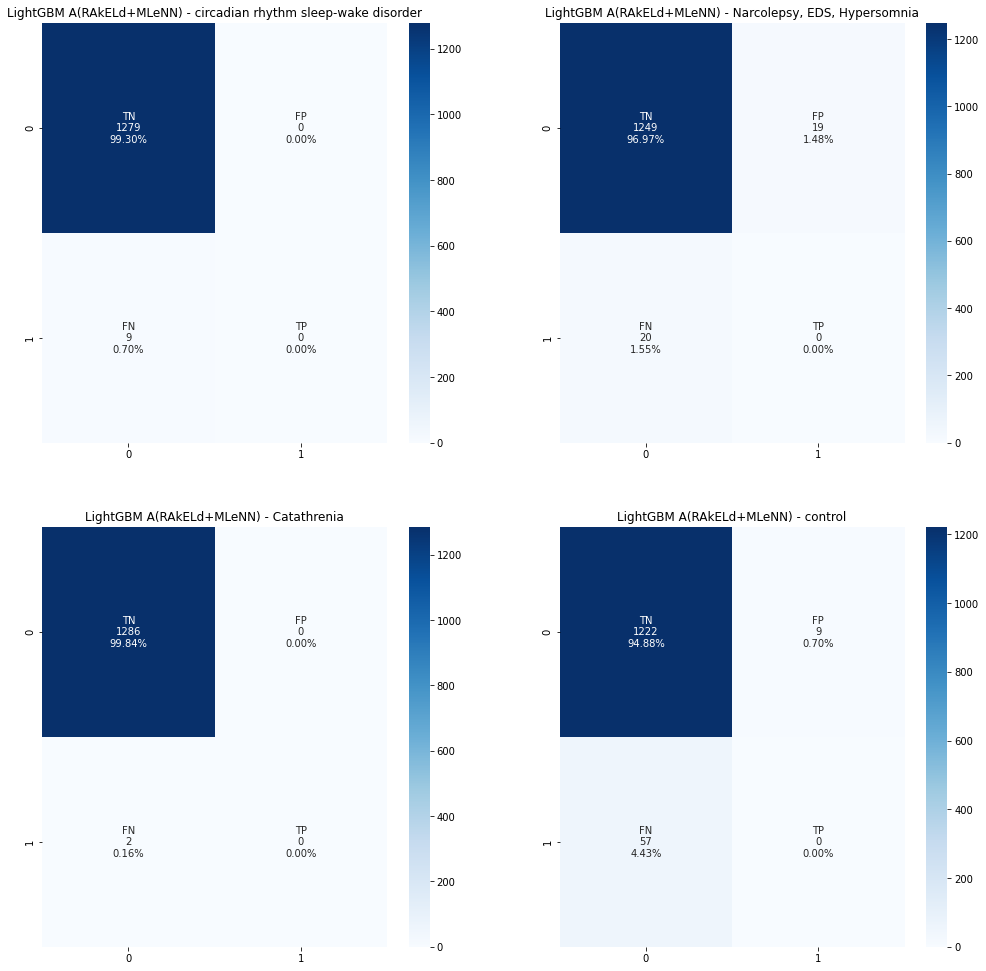

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
y_pred_a = rakeld_clf.best_estimator_.predict(X_test_a).toarray()
y_pred_proba_a = rakeld_clf.best_estimator_.predict_proba(X_test_a).toarray()

rakeld_res = eval_metrics(y_test_a, title='LightGBM A(RAkELd+MLeNN)', pred=y_pred_a, pred_proba=y_pred_proba_a, multilabel=True)

In [48]:
gc = gspread.service_account(filename='../input/sleep-research/sleep-research-2.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").get_worksheet(1)

In [49]:
for key in rakeld_res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+18, cell.col, rakeld_res[key])
        continue
        
    scores = rakeld_res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+18, cell.col, score)